In [26]:
import pandas as pd
from collections import defaultdict
from itertools import combinations
import matplotlib.pyplot as plt

In [27]:
# Load and Prepare Data

# Define file paths
behaviors_path = r'C:\Users\kcirt\Documents\DTU\CDTS\MINDsmall_train\\behaviors.tsv'
news_path = r'C:\Users\kcirt\Documents\DTU\CDTS\MINDsmall_train\\news.tsv'

# Load behaviors.tsv
behaviors_df = pd.read_csv(behaviors_path, sep='\t', 
                           names=['impression_id', 'user_id', 'time', 'history', 'impressions'])

# Split 'history' into lists of baskets based on ids
behaviors_df['history'] = behaviors_df['history'].fillna('').apply(lambda x: x.split())
baskets = behaviors_df['history'].tolist()

print(f"Total baskets loaded: {len(baskets)}")

# Load news.tsv
news_df = pd.read_csv(news_path, sep='\t', 
                      names=['news_id', 'category', 'subcategory', 'title', 'abstract', 'url', 'title_entities', 'abstract_entities'])

# Create a dictionary mapping 'news_id' to 'title'
news_title_dict = dict(zip(news_df['news_id'], news_df['title']))



Total baskets loaded: 156965


In [28]:
#Pass 1 

# Define parameters
min_support = 3000  # ~2% of 157,000 rows
hash_table_size = 200000  # Size of the hash table

# Initialize counters
item_count = defaultdict(int)
hash_table = [0] * hash_table_size

# Count individual items and hash pairs, skipping self-pairs
for basket in baskets:
    for item in basket:
        item_count[item] += 1

    # Generate item pairs using combinations and skip self-pairs
    for pair in combinations(basket, 2):
        # Skip self-pairs
        if pair[0] == pair[1]:
            continue

        hash_index = (hash(pair[0]) + hash(pair[1])) % hash_table_size
        hash_table[hash_index] += 1

print("Pass 1 completed.")


Pass 1 completed.


In [29]:
# Create a bitmap based on the minimum support threshold
bitmap = [1 if count >= min_support else 0 for count in hash_table]

# Filter out infrequent items
frequent_items = {item for item, count in item_count.items() if count >= min_support}
print(f"Number of frequent items: {len(frequent_items)}")

Number of frequent items: 227


In [30]:
#Pass 2
candidate_pairs = defaultdict(int)

for basket in baskets:
    # Filter to include only frequent items
    filtered_basket = [item for item in basket if item in frequent_items]

    for pair in combinations(filtered_basket, 2):
        # Skip self-pairs
        if pair[0] == pair[1]:
            continue

        hash_index = (hash(pair[0]) + hash(pair[1])) % hash_table_size
        if bitmap[hash_index]:
            candidate_pairs[pair] += 1

print("Pass 2 completed.")

#identify frequent pairs
frequent_pairs = {pair: count for pair, count in candidate_pairs.items() if count >= min_support}
print(f"Number of frequent pairs: {len(frequent_pairs)}")

Pass 2 completed.
Number of frequent pairs: 23


In [31]:
#enrich Frequent pairs with Article Titels 
enriched_pairs = []

for (news_id1, news_id2), count in frequent_pairs.items():
    title1 = news_title_dict.get(news_id1, "Unknown Title")
    title2 = news_title_dict.get(news_id2, "Unknown Title")
    enriched_pairs.append((news_id1, title1, news_id2, title2, count))

# Convert to a DataFrame for easier viewing
enriched_df = pd.DataFrame(enriched_pairs, columns=['News ID 1', 'Title 1', 'News ID 2', 'Title 2', 'Support Count'])

# Display the top 10 enriched frequent pairs
print(enriched_df.head(10))

  News ID 1                                            Title 1 News ID 2  \
0    N45794  Four flight attendants were arrested in Miami'...    N31801   
1      N871  Woman, suspect dead at 'Tarzan' actor Ron Ely'...    N43142   
2    N45794  Four flight attendants were arrested in Miami'...      N306   
3      N306  Kevin Spacey Won't Be Charged in Sexual Assaul...    N42620   
4    N31801  Joe Biden reportedly denied Communion at a Sou...    N42620   
5    N61864                               The News In Cartoons    N47020   
6    N16715  Mitch McConnell snubbed by Elijah Cummings' pa...    N31801   
7      N871  Woman, suspect dead at 'Tarzan' actor Ron Ely'...     N4020   
8      N871  Woman, suspect dead at 'Tarzan' actor Ron Ely'...    N45794   
9    N51706  Former NFL lineman Justin Bannan arrested for ...    N43142   

                                             Title 2  Support Count  
0  Joe Biden reportedly denied Communion at a Sou...           3258  
1  Former NBA first-rou

C:\Users\kcirt\AppData\Local\Temp\ipykernel_1464\2466218714.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


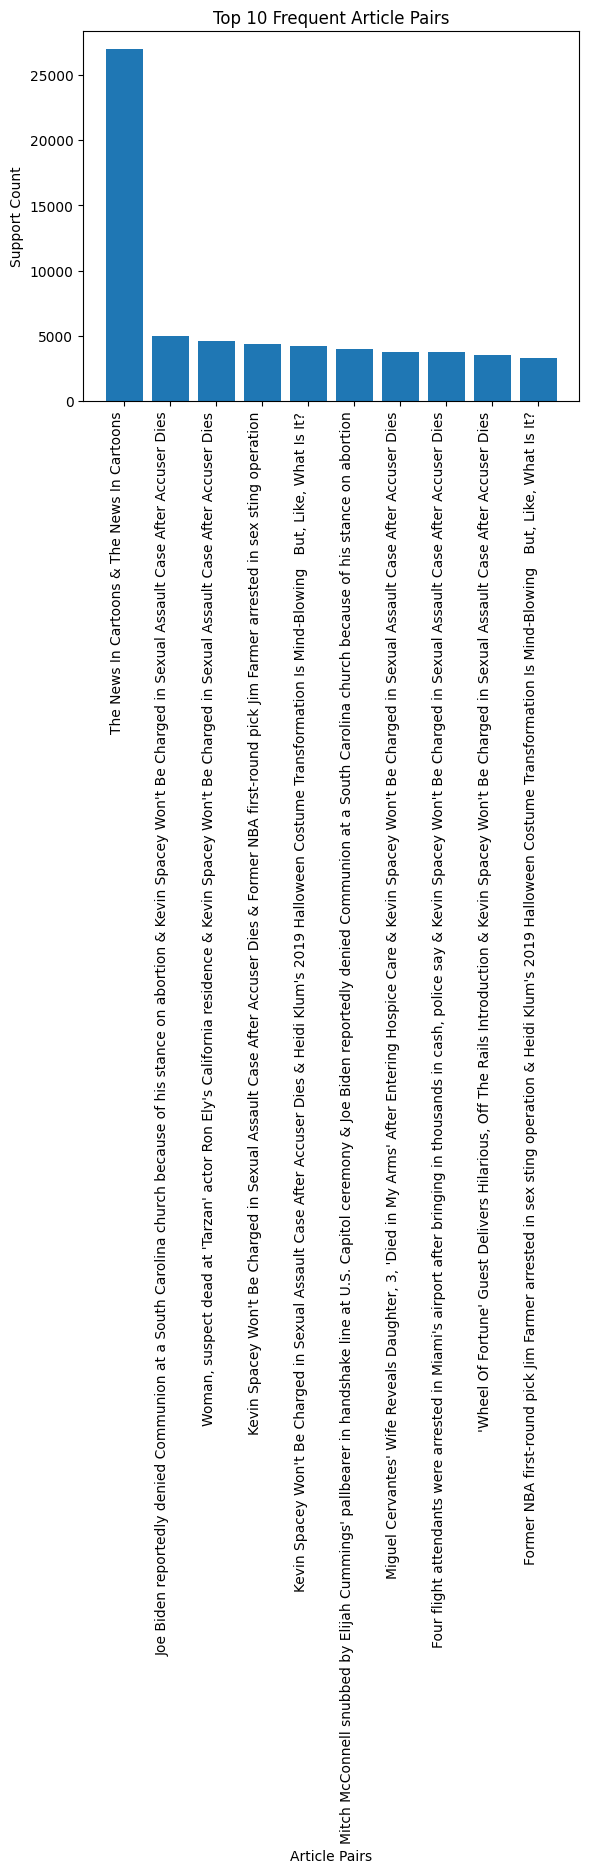

In [37]:
#Visualize the Top 10 Frequent Pairs

top_frequent_pairs = enriched_df.sort_values(by='Support Count', ascending=False).head(10)
pairs = [f"{row['Title 1']} & {row['Title 2']}" for _, row in top_frequent_pairs.iterrows()]
counts = top_frequent_pairs['Support Count'].tolist()

plt.bar(pairs, counts)
plt.xticks(rotation=90, ha='right')
plt.xlabel("Article Pairs")
plt.ylabel("Support Count")
plt.title("Top 10 Frequent Article Pairs")
plt.tight_layout()
plt.show()